### Exercise 1: Training a simple linear model

We do not know how to create a full neural network yet, by we know how to optimize a model.
We will try to solve a problem that consists in optimizing a simple model using an optimizer and the autograd.

Here is the physical problem:

* Let's consider a linear system characterized by a transmission matrix $\mathbf{H}$ (real) of size `n_out` $\times$ `n_in`.
* We send a collection of `n_inputs` random inputs, reprenseted by a matrix $\mathbf{X}$ of size `n_inputs` $\times$ `n_in`.
* We retrive the output corresponding to $\mathbf{Y} = \mathbf{X} \times \mathbf{H}^t$ of size `n_inputs` $\times$ `n_out`.
* We add a noise with a variance `noise_var` to $\mathbf{Y}$.

Because we know the system is fully described by a matrix $\mathbf{H}$, we will use a **network** with only one layer corresponding to a **dense layer** (i.e. one matrix multiplication, the coefficients being the parameters to be trained. 

Using the above example, create and train the system to find the correct matrix that correctly predict $\mathbf{Y}$.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Parameters**

In [2]:
# size of the system matrix
n_in, n_out = 6,10
# number of random input we use to estimate the response of the system
n_inputs = 25
# noise level (relative to the signal)
noise_var = 5e-2

**Generate data**

In [5]:
# transmission matrix
H = np.random.randn(n_out, n_in)

# inputs
X = np.random.randn(n_inputs, n_in)

# outputs
Y = X@H.transpose() 

# noise
noise = np.random.randn(*Y.shape)
noise *= np.linalg.norm(Y)/np.linalg.norm(noise)*noise_var

Y += noise

In [6]:
Y.shape

(25, 10)

**Convert data to PyTorch on `device`**

In [7]:
X_pt = torch.from_numpy(X).to(device).type(torch.float)
Y_pt = torch.from_numpy(Y).to(device).type(torch.float)
H_pt = torch.from_numpy(H).to(device).type(torch.float)

**Model**

A single dense layer (matrix multiplication).

Not deep learning!

In [13]:
model = torch.nn.Linear(n_in, n_out).to(device)

**Loss function and optimizer**

In [9]:
# create loss function
loss_fn = torch.nn.MSELoss(size_average=False) # Mean square error

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)


/opt/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [10]:

for iteration in range(50):
    Y_pred = model(X_pt)
    loss = loss_fn(Y_pred,Y_pt)
    
    optimizer.zero_grad() # before the backpropagation!   
    # backward propagation done by autograd
    loss.backward()
    
    # update the parameters
    optimizer.step()
    
    if iteration % 5 == 0:
        print(f"iteration = {iteration}\t loss = {loss.item():.2e}")


iteration = 0	 loss = 2.16e+03
iteration = 5	 loss = 2.31e+01
iteration = 10	 loss = 5.89e+00
iteration = 15	 loss = 3.87e+00
iteration = 20	 loss = 3.53e+00
iteration = 25	 loss = 3.47e+00
iteration = 30	 loss = 3.46e+00
iteration = 35	 loss = 3.46e+00
iteration = 40	 loss = 3.46e+00
iteration = 45	 loss = 3.46e+00


**Retrieve the estimater matrix and show the result**

In [11]:
H_hat = model.weight.detach().cpu().numpy()
# use detach() to remove the tracking of gradient, do it once the calculation is done
# cpu() to copy it back to the cpu memory from the GPU
# numpy() to covert PyTorch tensor to numpy array

Text(0.5, 1.0, 'Estiamte matrix')

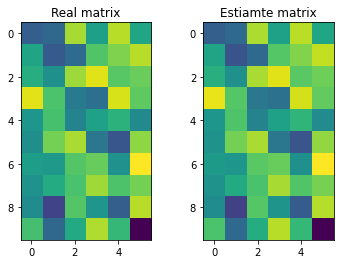

In [12]:
plt.figure()
plt.subplot(121)
plt.imshow(H)
plt.title('Real matrix')
plt.subplot(122)
plt.imshow(H_hat)
plt.title('Estiamte matrix')

### Exercice 2: Fully connected classifier for MNIST dataset


<br>
<center><figure>
    <img src='img/dense_net.svg' alt='missing'/>
</figure></center>

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 64
epochs = 10
learning_rate = 1e-3
device  = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
mnist_train = datasets.MNIST("./", train=True, 
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))]),
                             target_transform=None, 
                             download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST("./", train=False, 
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))]),
                             target_transform=None, 
                             download=True)

test_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [3]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 350 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('>> Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(in_features = 28*28, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 200)
        self.fc3 = nn.Linear(in_features = 200, out_features = 100)
        self.fc4 = nn.Linear(in_features = 100, out_features = 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.log_softmax(x, dim=1)
    
model = DenseNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300672
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.624926
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.519737
>> Test set: Average loss: 0.6849, Accuracy: 47870/60000 (79.8%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.701207
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.676404
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.187973
>> Test set: Average loss: 0.3039, Accuracy: 54622/60000 (91.0%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.509816
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.310495
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.148266
>> Test set: Average loss: 0.2424, Accuracy: 55710/60000 (92.8%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.251572
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.087974
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.466239
>> Test set: Average loss: 0.1956, Accuracy: 56591/60000 (94.3%)
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.232700
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.273678
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.135543
>> Test set: Av